In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc
import os
import json
import shutil
import networkx as nx
import math

In [2]:
adata = sc.read_h5ad('./PAGA_analysis/paga_result/paul15.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 2730 × 1000 
    obs: 'paul15_clusters', 'n_counts_all', 'n_counts', 'louvain', 'louvain_anno', 'dpt_pseudotime', 'distance', 'clusters'
    var: 'n_counts'
    uns: 'clusters_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'louvain', 'louvain_anno_colors', 'louvain_anno_sizes', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'paul15_clusters_colors', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca'
    varm: 'PCs'

In [4]:
def get_colors(adata,label,color_key):
    df_cell_colors = pd.DataFrame(index=adata.obs.index)
    df_cell_colors['label_color'] = ''
    labels_unique = adata.obs[label].cat.categories
    for i,x in enumerate(labels_unique):
        id_cells = np.where(adata.obs[label]==x)[0]
        df_cell_colors.loc[df_cell_colors.index[id_cells],'label_color'] = adata.uns[color_key][i]
    return(df_cell_colors['label_color'].tolist()) 

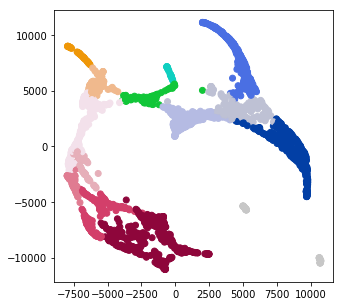

In [5]:
plt.figure(figsize=(5,5))
plt.scatter(adata.obsm['X_draw_graph_fa'][:,0],adata.obsm['X_draw_graph_fa'][:,1],
            c=get_colors(adata,'louvain_anno','louvain_anno_colors'))

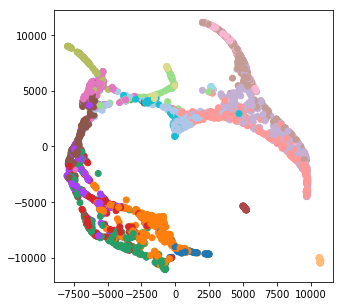

In [6]:
plt.figure(figsize=(5,5))
plt.scatter(adata.obsm['X_draw_graph_fa'][:,0],adata.obsm['X_draw_graph_fa'][:,1],
            c=get_colors(adata,'paul15_clusters','paul15_clusters_colors'))

In [7]:
adata.obs

,paul15_clusters,n_counts_all,n_counts,louvain,louvain_anno,dpt_pseudotime,distance,clusters
index,,,,,,,,
0,7MEP,353.0,703.637394,8,8,0.225547,0.225547,8
1,15Mo,2556.0,837.391041,1,1,0.273527,0.273527,1
2,3Ery,4649.0,608.988922,17,17,0.710177,0.710177,17
3,15Mo,4486.0,759.589389,2,2,0.267908,0.267908,2
4,3Ery,5205.0,603.214025,17,17,0.781936,0.781936,17
...,...,...,...,...,...,...,...,...
2725,2Ery,4873.0,600.109481,6,6,0.649136,0.649136,6
2726,13Baso,3553.0,749.875176,24,24/Mo,0.298525,0.298525,24/Mo
2727,7MEP,443.0,797.225734,8,8,0.196117,0.196117,8


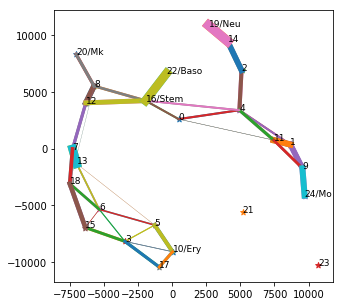

In [8]:
plt.figure(figsize=(5,5))
texts = adata.obs["louvain_anno"].cat.categories
x_coords = adata.uns['paga']['pos'][:,0]
y_coords = adata.uns['paga']['pos'][:,1]
edges_weights = adata.uns['paga']['connectivities']
# edges_tree = adata.uns['paga']['connectivities_tree']

for i,t in enumerate(texts):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, marker='*')
    for j in edges_weights[i].nonzero()[1]:
        plt.plot(x_coords[[i,j]],y_coords[[i,j]],linewidth=edges_weights[i,j]*10)
    plt.text(x+0.3, y+0.3, t, fontsize=9)
plt.show()

In [9]:
reportdir = './paga_report'

In [10]:
if(not os.path.exists(reportdir)):
        os.makedirs(reportdir)

In [11]:
list_cells = []
for i in range(adata.shape[0]):
    dict_coord_cells = dict()
    dict_coord_cells['cell_id'] = adata.obs_names[i]
    dict_coord_cells['x'] = adata.obsm['X_draw_graph_fa'][i,0]
    dict_coord_cells['y'] = adata.obsm['X_draw_graph_fa'][i,1]
    list_cells.append(dict_coord_cells)

In [12]:
with open(os.path.join(reportdir,'scatter.json'), 'w') as f:
    json.dump(list_cells, f)

In [13]:
G_graph = nx.from_numpy_matrix(edges_weights.toarray())
texts = adata.obs["louvain_anno"].cat.categories
x_coords = adata.uns['paga']['pos'][:,0]
y_coords = adata.uns['paga']['pos'][:,1]
edges_weights = adata.uns['paga']['connectivities']

In [14]:
dict_edge_len = dict()
for edge_i in G_graph.edges():
    p_n1 = [x_coords[edge_i[0]],y_coords[edge_i[0]]]
    p_n2 = [x_coords[edge_i[1]],y_coords[edge_i[1]]]
    len_edge_i = math.sqrt(((p_n1[0]-p_n2[0])**2)+((p_n1[1]-p_n2[1])**2))
    dict_edge_len[edge_i] = len_edge_i

In [15]:
len_min = min(dict_edge_len.values())
step = len_min/3
list_lines = []
for edge_i in G_graph.edges():
    pseudotime_new = np.arange(0,dict_edge_len[edge_i],step)
    c1 = np.interp(pseudotime_new,[0,dict_edge_len[edge_i]],[x_coords[edge_i[0]],x_coords[edge_i[1]]])
    c2 = np.interp(pseudotime_new,[0,dict_edge_len[edge_i]],[y_coords[edge_i[0]],y_coords[edge_i[1]]])        
    if(pseudotime_new[-1]<dict_edge_len[edge_i]):
        c1 = np.append(c1,x_coords[edge_i[1]])
        c2 = np.append(c2,y_coords[edge_i[1]]) 

    dict_coord_lines = dict()
    dict_coord_lines['branch_id'] = [[str(edge_i[0]),str(edge_i[1])]]
    dict_coord_lines['xy'] = [{'x':c1[j],
                                 'y':c2[j]} for j in range(c1.shape[0])]
    list_lines.append(dict_coord_lines)

In [16]:
with open(os.path.join(reportdir,'paga.json'), 'w') as f:
    json.dump(list_lines, f)

In [17]:
G_graph = nx.from_numpy_matrix(edges_weights.toarray())

dict_nodes = dict()
list_edges = []

texts = adata.obs["louvain_anno"].cat.categories
x_coords = adata.uns['paga']['pos'][:,0]
y_coords = adata.uns['paga']['pos'][:,1]
edges_weights = adata.uns['paga']['connectivities']

for node_i in G_graph.nodes():
    dict_nodes_i = dict()
#     dict_nodes_i['node_id'] = str(node_i)
    dict_nodes_i['node_name'] = texts[node_i]
    dict_nodes_i['xy'] = {'x':x_coords[node_i],'y':y_coords[node_i]}
    dict_nodes[node_i] = dict_nodes_i


for edge_i in G_graph.edges():
    dict_edges = dict()
    dict_edges['nodes'] = [str(edge_i[0]),str(edge_i[1])]
    dict_edges['weight'] = edges_weights[edge_i[0],edge_i[1]]
    list_edges.append(dict_edges)

In [18]:
with open(os.path.join(reportdir,'paga_nodes.json'), 'w') as f:
    json.dump(dict_nodes, f)

with open(os.path.join(reportdir,'paga_edges.json'), 'w') as f:
    json.dump(list_edges, f)

In [19]:
list_metadata = []
label_colors = get_colors(adata,'paul15_clusters','paul15_clusters_colors')
cluster_colors = get_colors(adata,'louvain_anno','louvain_anno_colors')

for i in range(adata.shape[0]):
    dict_metadata = dict()
    dict_metadata['cell_id'] = adata.obs_names[i]
    dict_metadata['label'] = adata.obs['paul15_clusters'].tolist()[i]
    dict_metadata['label_color'] = label_colors[i]
    dict_metadata['cluster'] = adata.obs['louvain_anno'].tolist()[i]
    dict_metadata['cluster_color'] = cluster_colors[i]
    list_metadata.append(dict_metadata)

In [20]:
with open(os.path.join(reportdir,'metadata.json'), 'w') as f:
    json.dump(list_metadata, f)

In [21]:
df_genes = pd.DataFrame(adata.raw.X,index=adata.raw.obs_names,columns=adata.raw.var_names)

In [22]:
df_genes

index,0610007L01Rik,0610009O20Rik,0610010K14Rik,0910001L09Rik,1100001G20Rik,1110002B05Rik,1110004E09Rik,1110007A13Rik,1110007C09Rik,1110013L07Rik,...,hnRNP A2/B1,mFLJ00022,mKIAA0007,mKIAA0569,mKIAA0621,mKIAA1027,mKIAA1575,mKIAA1994,rp9,slc43a2
index,,,,,,,,,,,,,,,,,,,,,
0,-0.676355,-0.505616,-1.216430,-0.752010,-0.196188,-0.733152,-0.626113,-0.821603,-0.330976,-0.296973,...,-1.408926,-0.536264,-1.057773,-0.522993,-0.139468,-1.670896,-0.488628,-0.533720,0.430855,-0.242065
1,-0.676355,-0.505616,-0.072501,0.711620,-0.196188,0.802736,1.056846,-0.821603,-0.330976,-0.296973,...,0.292946,1.403415,0.043368,2.347152,-0.139468,-0.635528,-0.488628,-0.533720,-0.157039,-0.242065
2,0.930185,-0.505616,1.071428,0.711620,-0.196188,-0.733152,2.041315,1.977757,-0.330976,-0.296973,...,1.288476,-0.536264,1.144509,2.347152,-0.139468,0.733155,1.559593,2.081515,0.847973,-0.242065
3,0.930185,-0.505616,1.071428,0.711620,-0.196188,2.338625,1.056846,1.396837,-0.330976,3.011624,...,1.354851,2.538054,0.687494,-0.522993,-0.139468,1.235750,-0.488628,-0.533720,0.430855,-0.242065
4,-0.676355,3.482872,2.409739,0.711620,-0.196188,-0.733152,2.041315,0.578077,-0.330976,-0.296973,...,0.683892,1.403415,1.788635,-0.522993,-0.139468,1.235750,2.757726,3.731545,1.435867,-0.242065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2725,-0.676355,-0.505616,-0.072501,-0.752010,-0.196188,2.833071,2.739806,0.578077,-0.330976,-0.296973,...,1.417821,-0.536264,1.144509,-0.522993,-0.139468,0.733155,1.559593,-0.533720,1.171514,-0.242065
2726,-0.676355,-0.505616,2.409739,1.567789,-0.196188,2.338625,-0.626113,0.578077,-0.330976,-0.296973,...,0.437541,-0.536264,0.043368,2.347152,10.881874,1.235750,-0.488628,-0.533720,0.430855,-0.242065
2727,-0.676355,-0.505616,-0.072501,-0.752010,-0.196188,-0.733152,1.056846,-0.821603,-0.330976,3.011624,...,-1.408926,-0.536264,0.687494,-0.522993,-0.139468,-0.635528,-0.488628,-0.533720,-1.162050,-0.242065


In [23]:
top_genes = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

In [24]:
cm = mpl.cm.get_cmap('viridis',512)
for g in top_genes:
    list_genes = []
    norm = mpl.colors.Normalize(vmin=0, vmax=max(df_genes[g]),clip=True)
    for x in adata.obs_names:
        dict_genes = dict()
        dict_genes['cell_id'] = x
        dict_genes['color'] = mpl.colors.to_hex(cm(norm(df_genes.loc[x,g])))
        list_genes.append(dict_genes)
    with open(os.path.join(reportdir,'gene_'+g+'.json'), 'w') as f:
        json.dump(list_genes, f)

In [25]:
shutil.make_archive('paga_report', 'zip', reportdir)

'/Users/huidong/Projects/SinglecellVR/paga_report.zip'